# Анализ на научни статии за COVID-19

В това предизвикателство ще продължим с темата за пандемията от COVID и ще се фокусираме върху обработката на научни статии по темата. Съществува [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) с повече от 7000 (към момента на писане) статии за COVID, достъпни с метаданни и резюмета (а за около половината от тях е предоставен и пълният текст).

Пълен пример за анализ на този набор от данни с помощта на когнитивната услуга [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) е описан [в този блог пост](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Ще обсъдим опростена версия на този анализ.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Получаване на данните

Първо, трябва да вземем метаданните за CORD документите, с които ще работим.

**NOTE**: Не предоставяме копие на набора от данни като част от това хранилище. Може да се наложи първо да изтеглите файла [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) от [този набор от данни в Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Може да е необходима регистрация в Kaggle. Също така можете да изтеглите набора от данни без регистрация [оттук](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), но той ще включва всички пълни текстове в допълнение към файла с метаданни.

Ще се опитаме да получим данните директно от онлайн източник, но ако това не успее, ще трябва да изтеглите данните, както е описано по-горе. Също така има смисъл да изтеглите данните, ако планирате да експериментирате с тях допълнително, за да спестите време за чакане.

> **NOTE** че наборът от данни е доста голям, около 1 Gb, и следният ред код може да отнеме много време за изпълнение! (~5 минути)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Сега ще преобразуваме колоната за дата на публикуване в `datetime` и ще начертаем хистограма, за да видим диапазона на датите на публикуване.


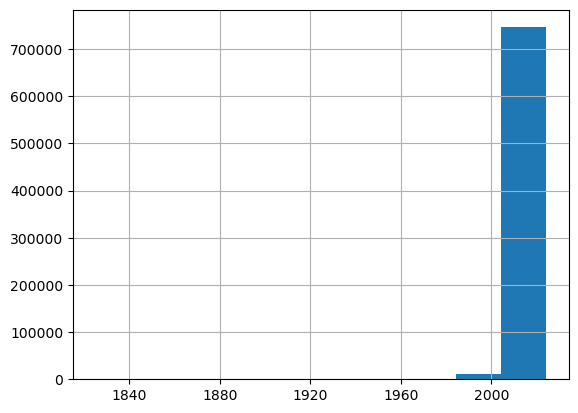

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Извличане на структурирани данни

Нека видим какъв вид информация можем лесно да извлечем от резюметата. Едно от нещата, които може да ни интересуват, е да разберем кои стратегии за лечение съществуват и как са се развивали с времето. За начало можем ръчно да съставим списък с възможните медикаменти, използвани за лечение на COVID, както и списък с диагнози. След това преглеждаме тези списъци и търсим съответните термини в резюметата на научните статии.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Добавихме множество колони към нашия dataframe, които съдържат броя на случаите, в които дадено лекарство/диагноза присъства в резюмето.

> **Забележка**: Добавяме интервал в началото на думата, когато търсим подниз. Ако не го направим, може да получим грешни резултати, защото *хлороквин* би се намерил и вътре в подниз *хидроксихлороквин*. Освен това, принуждаваме конвертирането на колоната с резюмета към `str`, за да избегнем грешка - опитайте да премахнете `str` и вижте какво ще се случи.

За да улесним работата с данните, можем да извлечем подрамка, която съдържа само броя на лекарствата, и да изчислим натрупания брой на срещанията. Това ни дава най-популярното лекарство:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

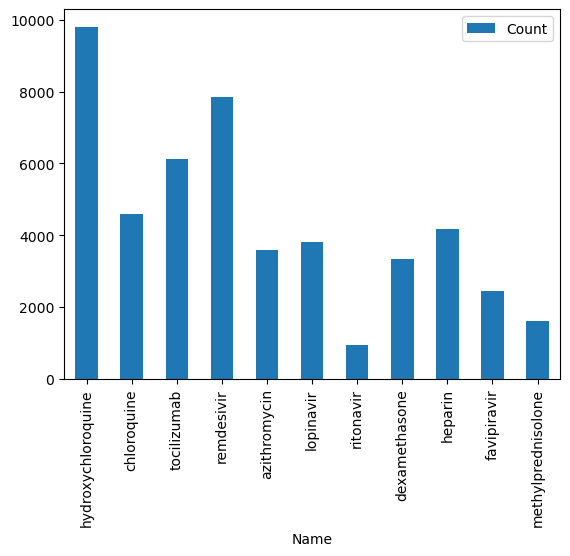

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Търсене на тенденции в стратегията за лечение

В примера по-горе сме използвали `sum`, за да съберем всички стойности, но можем да направим същото и на месечна база:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

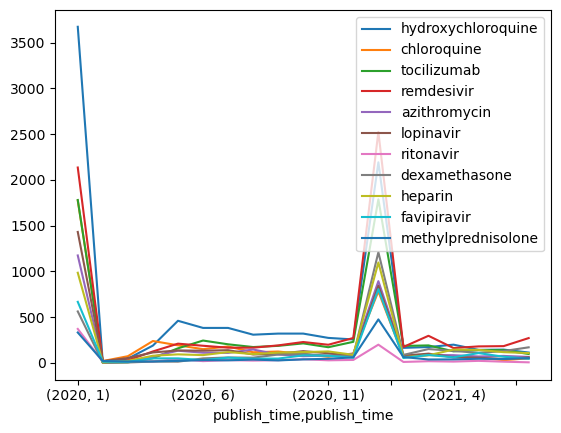

In [152]:
dfmt.plot()
plt.show()

Интересно наблюдение е, че имаме огромни пикове на две места: януари 2020 и януари 2021. Това се дължи на факта, че някои статии нямат ясно посочена дата на публикуване и са отбелязани като януари на съответната година.

За да направим данните по-разбираеми, нека визуализираме само няколко лекарства. Също така ще "изтрием" данните за януари и ще ги заменим със средна стойност, за да получим по-привлекателна графика:


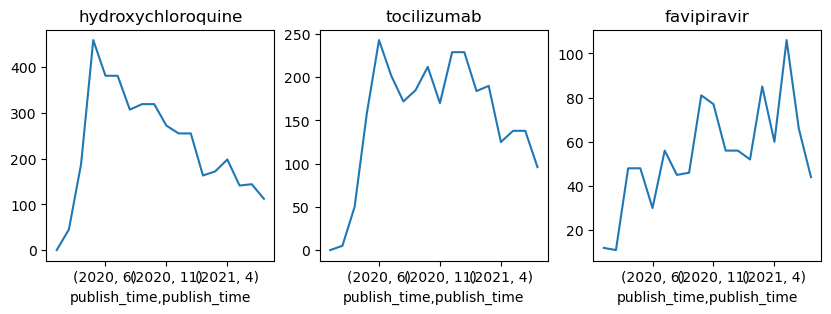

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

Наблюдавайте как популярността на хидроксихлорохин се увеличаваше през първите няколко месеца, а след това започна да намалява, докато броят на споменаванията на фавипиравир показва стабилно увеличение. Друг добър начин за визуализиране на относителната популярност е използването на **stack plot** (или **area plot** в терминологията на Pandas):


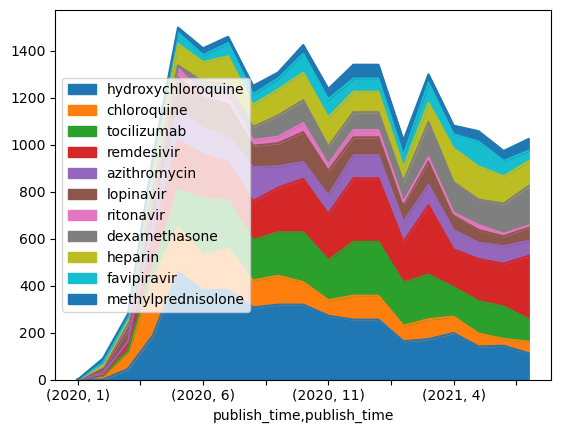

In [154]:
dfmt.plot.area()
plt.show()

Дори още повече, можем да изчислим относителната популярност в проценти:


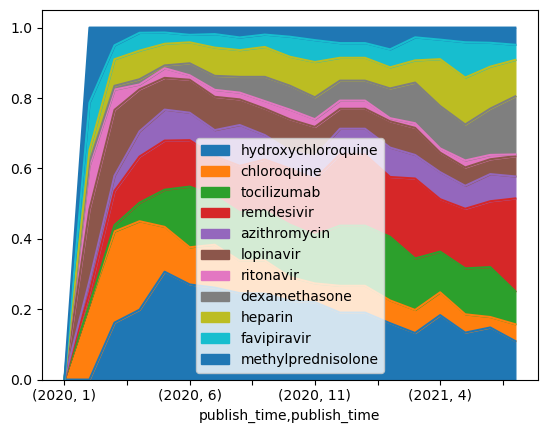

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Съответствие между лекарства и диагнози

Една от най-интересните връзки, които можем да изследваме, е как различни диагнози се лекуват с различни лекарства. За да я визуализираме, трябва да изчислим **карта на честотата на съвместна поява**, която показва колко пъти два термина се споменават в една и съща статия.

Такава карта всъщност представлява двумерна матрица, която най-добре се представя чрез **numpy array**. Ще изчислим тази карта, като преминем през всички резюмета и отбележим съответните обекти, които се срещат там:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Един от начините за визуализиране на тази матрица е да се начертае **heatmap**:


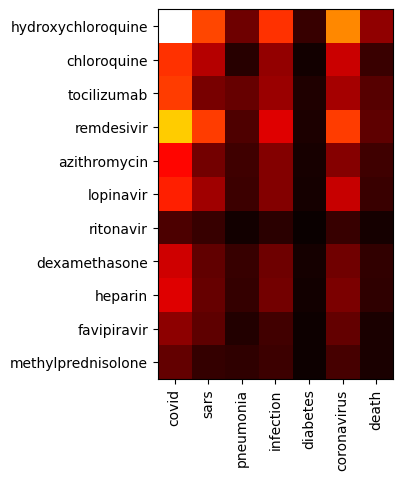

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Визуализацията може да бъде още по-добра с помощта на така наречената **Sankey** диаграма! `matplotlib` няма вградена поддръжка за този тип диаграма, затова ще трябва да използваме [Plotly](https://plotly.com/python/), както е описано [в този урок](https://plotly.com/python/sankey-diagram/).

За да създадем Sankey диаграма с Plotly, трябва да изградим следните списъци:
* Списък `all_nodes` с всички възли в графа, който ще включва както медикаменти, така и диагнози
* Списък с индекси на източници и цели - тези списъци ще показват кои възли отиват в лявата и кои в дясната част на диаграмата
* Списък с всички връзки, като всяка връзка се състои от:
   - Индекс на източника в масива `all_nodes`
   - Индекс на целта
   - Стойност, която показва силата на връзката. Това е точно стойността от нашата матрица за съвместна поява.
   - По желание, цвят на връзката. Ще направим опция за подчертаване на някои термини за по-голяма яснота.

Общият код за създаване на Sankey диаграма е структуриран като отделна функция `sankey`, която приема два списъка (категории на източници и цели) и матрица за съвместна поява. Функцията също така ни позволява да зададем праг и да пропуснем всички връзки, които са по-слаби от този праг - това прави диаграмата малко по-малко сложна.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Заключение

Видяхте, че можем да използваме доста прости методи за извличане на информация от неструктурирани източници на данни, като текст. В този пример използвахме съществуващия списък с лекарства, но би било много по-мощно да се използват техники за обработка на естествен език (NLP) за извличане на обекти от текст. В [тази публикация в блога](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) описваме как да използвате облачни услуги за извличане на обекти. Друга опция би била използването на Python NLP библиотеки като [NLTK](https://www.nltk.org/) - подход за извличане на информация от текст с помощта на NLTK е описан [тук](https://www.nltk.org/book/ch07.html).


## Предизвикателство

Продължете изследването на данните от статията за COVID по следните направления:

1. Създайте матрица на съвместна поява на различни медикаменти и вижте кои медикаменти често се срещат заедно (т.е. споменати в един абстракт). Можете да модифицирате кода за създаване на матрица на съвместна поява за медикаменти и диагнози.
1. Визуализирайте тази матрица с помощта на топлинна карта.
1. Като допълнителна цел, може да опитате да визуализирате съвместната поява на медикаменти с помощта на [диаграма с акорди](https://en.wikipedia.org/wiki/Chord_diagram). [Тази библиотека](https://pypi.org/project/chord/) може да ви помогне да създадете диаграма с акорди.
1. Като друга допълнителна цел, опитайте да извлечете дозировките на различни медикаменти (като **400mg** в *приемайте 400mg хлорохин дневно*) с помощта на регулярни изрази и създайте dataframe, който показва различните дозировки за различните медикаменти. **Забележка**: вземете предвид числовите стойности, които са в близка текстова близост до името на медикамента.



---

**Отказ от отговорност**:  
Този документ е преведен с помощта на AI услуга за превод [Co-op Translator](https://github.com/Azure/co-op-translator). Въпреки че се стремим към точност, моля, имайте предвид, че автоматизираните преводи може да съдържат грешки или неточности. Оригиналният документ на неговия роден език трябва да се счита за авторитетен източник. За критична информация се препоръчва професионален човешки превод. Ние не носим отговорност за недоразумения или погрешни интерпретации, произтичащи от използването на този превод.
